In [1]:
%gui qt5
import datetime
from collections import defaultdict
import ibapi
from tws_async import TWSClientQt, iswrapper, Stock

In [2]:
# sample application
class TWS(TWSClientQt):
    def __init__(self):
        TWSClientQt.__init__(self)
        self._reqIdSeq = 0
        self._histData = defaultdict(list)

    def getReqId(self):
        """
        Get new request ID (integer).
        """
        assert self._reqIdSeq
        newId = self._reqIdSeq
        self._reqIdSeq += 1
        return newId
    
    def popHistData(self, reqId):
        """
        Remove and return the historical data that was downloaded for the given reqId.
        """
        return self._histData.pop(reqId)
    
    @iswrapper
    def nextValidId(self, reqId: int):
        self._reqIdSeq = reqId

    @iswrapper
    def tickPrice(self, reqId: int,
            tickType: ibapi.ticktype.TickType,
            price: float,
            attrib: ibapi.common.TickAttrib):
        print('{} price {}'.format(reqId, price))

    @iswrapper
    def tickSize(self, reqId: int,
            tickType: ibapi.ticktype.TickType,
            size: int):
        print('{} size {}'.format(reqId, size))

    @iswrapper
    def historicalData(self, reqId: int, date: str, open: float, high: float,
            low: float, close: float, volume: int, barCount: int,
            WAP: float, hasGaps: int):
        self._histData[reqId].append((date, open, high, low, close, volume))
        
    @iswrapper
    def historicalDataEnd(self, reqId: int, start: str, end: str):
        print('Historical request {} is finished'.format(reqId))

        
if 'tws' in locals():
    tws.disconnect()
tws = TWS()
tws.connect('127.0.0.1', 7497, clientId=1)

ERROR:root:ERROR -1 2104 Market data farm connection is OK:eufarm
ERROR:root:ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR:root:ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR:root:ERROR -1 2106 HMDS data farm connection is OK:cashhmds
ERROR:root:ERROR -1 2106 HMDS data farm connection is OK:ushmds


In [3]:
# request historical bar data
contract = Stock('TSLA')
reqId = tws.getReqId()
tws.reqHistoricalData(reqId, contract,
        endDateTime=datetime.datetime.utcnow().strftime('%Y%m%d %H:%M:%S UTC'),
        durationStr='60 D',
        barSizeSetting='1 hour',
        whatToShow='TRADES',
        useRTH=False,
        formatDate=1,
        chartOptions=None)

Historical request 488 is finished


In [4]:
# fetch data when it's finished
data = tws.popHistData(reqId)

In [5]:
# process data
import pandas as pd  
df = pd.DataFrame.from_records(data)
df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']
df['datetime'] =  pd.to_datetime(df['datetime'])
# df.set_index('datetime', inplace=True)
display(df.head())
display(df.tail())

,datetime,open,high,low,close,volume
0,2017-03-28 10:00:00,271.00,271.00,271.0,271.00,2
1,2017-03-28 11:00:00,271.00,271.00,271.0,271.00,0
2,2017-03-28 12:00:00,270.28,270.28,269.0,269.00,20
3,2017-03-28 13:00:00,268.40,279.40,268.0,275.25,1064
4,2017-03-28 14:00:00,275.49,278.85,271.2,277.75,1671


,datetime,open,high,low,close,volume
937,2017-06-21 19:00:00,372.51,373.14,371.02,371.56,2349
938,2017-06-21 20:00:00,371.65,374.22,371.31,373.84,4687
939,2017-06-21 21:00:00,373.77,376.99,373.35,376.40,8341
940,2017-06-21 22:00:00,376.40,376.50,374.90,375.20,683
941,2017-06-21 23:00:00,375.75,376.00,375.38,375.38,11


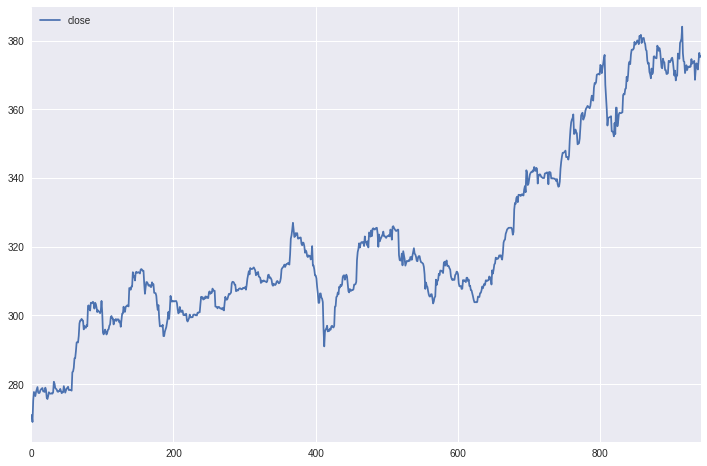

In [6]:
# plot data
%matplotlib inline
import seaborn as sns
df.plot(y='close', figsize=(12,8))

In [7]:
# subscribe to realtime tick data
reqId = tws.getReqId()
tws.reqMktData(reqId, contract, genericTickList='', snapshot=False,
        regulatorySnapshot=False, mktDataOptions=[])

489 price 375.38
489 size 1
489 price 375.95
489 size 1
489 price 375.38
489 size 1
489 size 1
489 size 1
489 size 1
489 size 40966
489 price 376.99
489 price 368.02
489 price 372.24
489 price 374.35


In [8]:
# cancel realtime ticks
tws.cancelMktData(reqId)

In [9]:
# asyncio integration
import asyncio
import quamash

async def coro(seconds):
    print('starting coroutine...')
    await asyncio.sleep(seconds)
    print('coroutine finished')

loop = quamash.QEventLoop()
asyncio.set_event_loop(loop)

task = asyncio.ensure_future(coro(seconds=1))
# note that the Qt event loop doesn't need to be started as it's already running

starting coroutine...
coroutine finished
